In [5]:
!pip install openpyxl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.0/250.0 kB 5.0 MB/s eta 0:00:0000:01


# Insurance Final Project - Solvency II

$\textit{MSc Mathematical Engineering - Track Quantitative Finance}$, $\textbf{Politecnico di Milano}$.

$\textit{Noé Debrois}$ \&$\textit{Vincent Haïk Karakoseian}$, $\textbf{March-April 2024}$.

### Step 0 : Import the libraries

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Step 1 : Simulate the fund made of 80% equity and 20% property using GBM :

Geometric Brownian motion (GBM) S is defined by S0 > 0 and the dynamics as defined in the following Stochastic Differential Equation (SDE):


$\Large dS_t = \mu S_t dt + \sigma S_t dW_t$

Integrated Form:

 - $\log S_t = \log S_0 + \int_{0}^{t} (\mu-\frac{\sigma^2}{2}) \,ds + \int_{0}^{t} \sigma \,dW_s $

 - i.e : $\log S_t = \log S_0 + (\mu-\frac{\sigma^2}{2})t + \sigma W_t $

 - i.e : $\log S_t \sim N(\log S_0 + (\mu-\frac{\sigma^2}{2})t, \sigma^2 t)$

Explicit Expression:

$\Large S_t = S_0 {\rm e}^{(\mu-\frac{\sigma^2}{2})t + \sigma W_t}$

In [7]:
# number of steps
n = 50
# time in years
T = 50
# number of simulations
M = 100
# initial stock price
F0 = 100000

In [24]:
# Path to your Excel file
file_path = 'EIOPA/EIOPA_RFR_20240229_Term_Structures.xlsx'

# Read Excel file
df = pd.read_excel(file_path, "RFR_spot_no_VA", usecols="S", )
df = df[9:]
df = df.rename(columns={'Unnamed: 18': 'EIOPA IT without VA, FEB'})
df

,"EIOPA IT without VA, FEB"
9,0.03597
10,0.03127
11,0.02893
12,0.02763
13,0.02685
...,...
154,0.03136
155,0.03137
156,0.03138
157,0.03139


In [25]:
def EQt(r,sigma_EQt,poids_EQt):
    EQ0 = F0*poids_EQt
    dt = T/n
    EQt = np.exp((r - sigma_EQt ** 2 / 2) * dt + sigma_EQt * np.random.normal(0, np.sqrt(dt), size=(M,n)).T)
    EQt = np.vstack([np.ones(M), EQt])
    EQt = EQ0 * EQt.cumprod(axis=0)
    return EQt
    
def PRt(r,sigma_PRt,poids_PRt):
    PR0 = F0*poids_PRt
    dt = T/n
    PRt = np.exp((r - sigma_PRt ** 2 / 2) * dt + sigma_PRt * np.random.normal(0, np.sqrt(dt), size=(M,n)).T)
    PRt = np.vstack([np.ones(M), PRt])
    PRt = PR0 * PRt.cumprod(axis=0)
    return PRt

def Ft(r,sigma_EQt,poids_EQt,sigma_PRt,poids_PRt):
    Ft=EQt(r,sigma_EQt,poids_EQt)+PRt(r,sigma_PRt,poids_PRt)
    return Ft

$\textbf{Explanations :}$\
The code simulates paths of asset prices (equity and property) using the Geometric Brownian Motion (GBM) model, and then merges it together to build our portfolio :

- $T$ represents the total time horizon.
- $n$ is the number of time steps.
- $r$ is the Risk Free Rate derived from the yield curve (EIOPA IT without VA 31.03.24).
- sigma ($\sigma$) is the volatility of the asset.
- $M$ is the number of simulation paths.
- np.random.normal(0, np.sqrt(dt), size=(M, n)).T generates random normal variables for each time step and each simulation path.

The simulation is performed using numpy arrays for efficiency.\
The arrays EQt and PRt are multiplied by the initial asset price F0 and the cumulative product of elements along each simulation path is calculated, representing the growth of asset prices over time according to the GBM model.\
The result is a matrix Ft = EQt + PRt representing our simulated portfolio over time for multiple paths.\

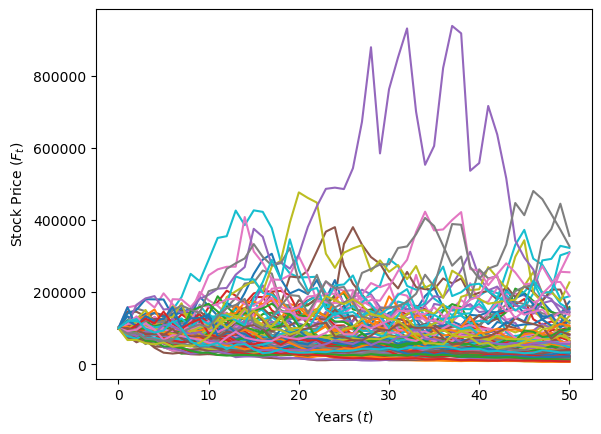

In [26]:
time = np.linspace(0,T,n+1)

# Require numpy array that is the same shape as St
tt = np.full(shape=(M,n+1), fill_value=time).T

plt.plot(tt, Ft(r=0,sigma_EQt=0.2,poids_EQt=0.8,sigma_PRt=0.1,poids_PRt=0.2))
plt.xlabel("Years $(t)$")
plt.ylabel("Stock Price $(F_t)$")
plt.show()